[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Segment Images with Segment Anything 3 (SAM3)

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-segment-anything-3.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://www.youtube.com/watch?v=G1AEuFwQrWU) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/sam3/) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/sam3)

SAM 3 (Segment Anything Model 3) extends the SAM series by moving from segmenting individual objects to understanding and segmenting all instances of a concept in images and videos. It introduces Promptable Concept Segmentation (PCS), where users specify a concept through short noun phrases like “striped cat” or by providing visual exemplars. The model detects, segments, and tracks every matching object, preserving identities across frames.


## Environment setup

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM 3 checkpoints.

- Request access to the SAM 3 checkpoints on the official Hugging Face [repo](https://github.com/facebookresearch/sam3).
- Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
- In Colab, go to the left pane and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.








In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Tue Nov 25 18:18:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [4]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

Cloning into 'sam3'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 572 (delta 47), reused 36 (delta 36), pack-reused 429 (from 2)
Receiving objects: 100% (572/572), 58.94 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1

/content


In [3]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 5.7 MB/s eta 0:00:00


### Download example data

Downloads example images. You can use these or replace them with your own images.

## Restart before running below cell

## Load SAM3 Image Predictor

On Ampere GPUs (compute capability ≥ 8), we enable TensorFloat-32 (TF32) for matrix multiplications and convolutions. This allows PyTorch to use tensor cores to accelerate FP32 computations while maintaining similar numerical accuracy.

In [4]:
import torch

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [5]:
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

model = build_sam3_image_model()
processor = Sam3Processor(model, confidence_threshold=0.3)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

## Few utils to parse and visualize the result

In [6]:
import supervision as sv

def from_sam(sam_result: dict) -> sv.Detections:
    xyxy = sam_result["boxes"].to(torch.float32).cpu().numpy()
    confidence = sam_result["scores"].to(torch.float32).cpu().numpy()

    mask = sam_result["masks"].to(torch.bool)
    mask = mask.reshape(mask.shape[0], mask.shape[2], mask.shape[3]).cpu().numpy()

    return sv.Detections(
        xyxy=xyxy,
        confidence=confidence,
        mask=mask
    )

In [7]:
import supervision as sv
from PIL import Image
from typing import Optional


COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])


def annotate(image: Image.Image, detections: sv.Detections, label: Optional[str] = None) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )
    box_annotator = sv.BoxAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        thickness=1
    )
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.4,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)

    if label:
        labels = [
            f"{label} {confidence:.2f}"
            for confidence in detections.confidence
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

## SAM 3 text prompt

There are 6 vertical pillar objects detected in the image.



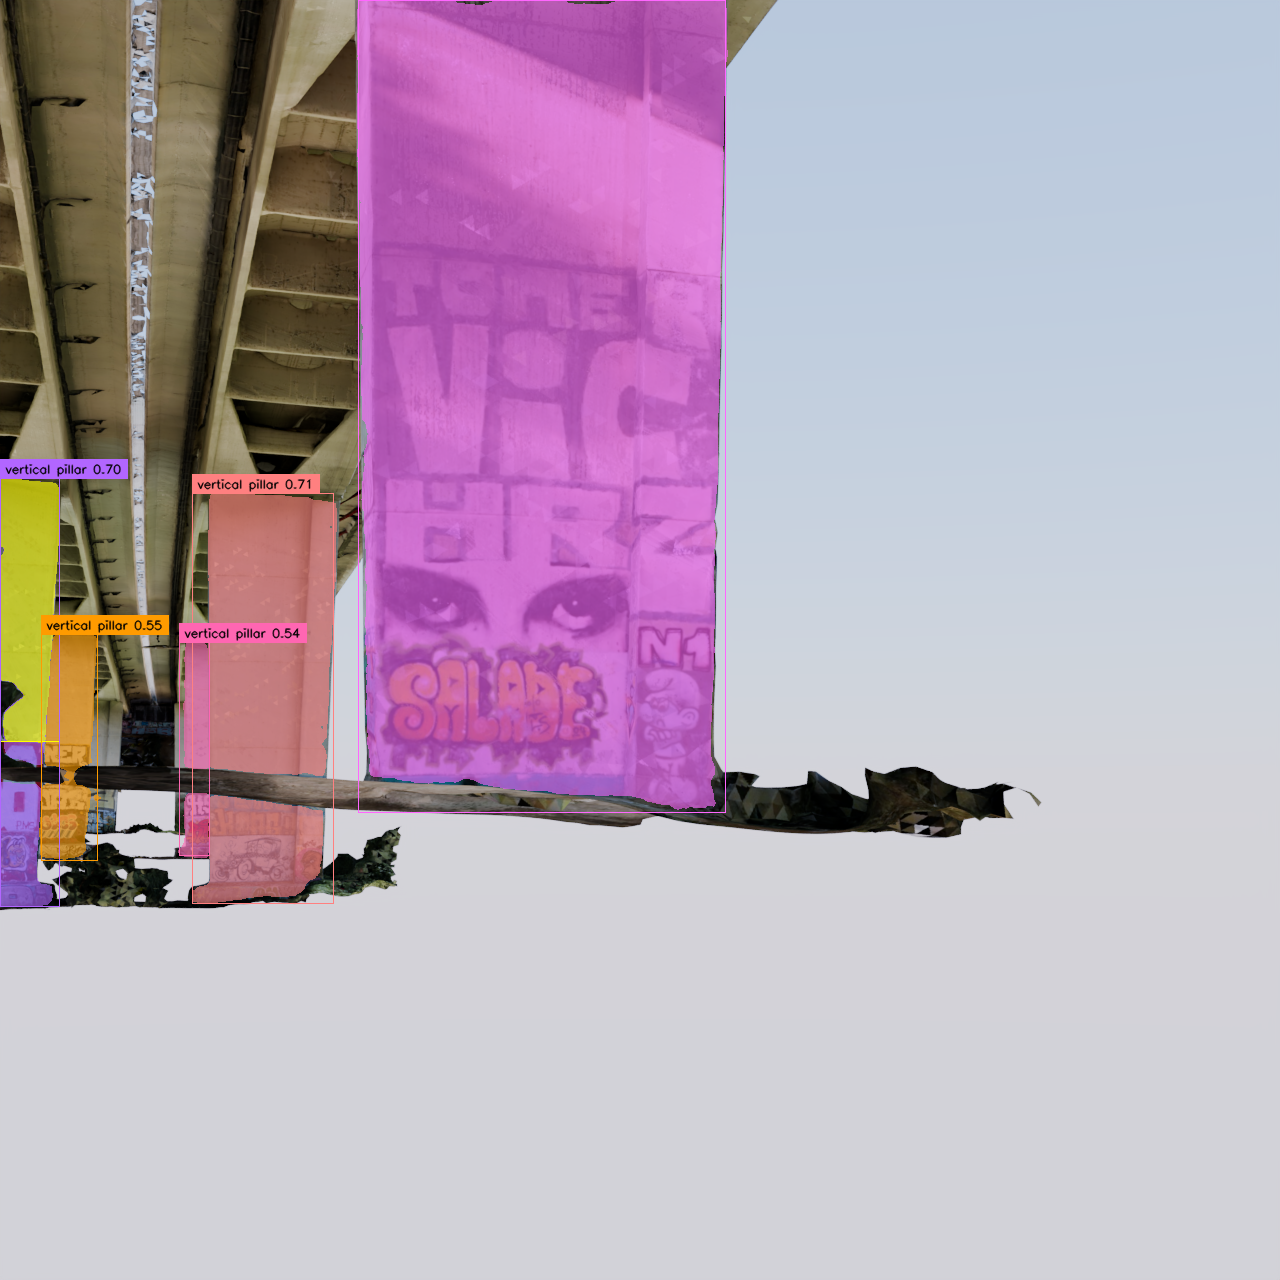

In [9]:
from PIL import Image
from IPython.display import display

PROMPT = "vertical pillar"
IMAGE_PATH = '/content/Data/rgb_00000.png'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=PROMPT)

There are 15 vertical pillar objects detected in the image.

There are 15 concrete beam objects detected in the image.

There are 15 plant objects detected in the image.



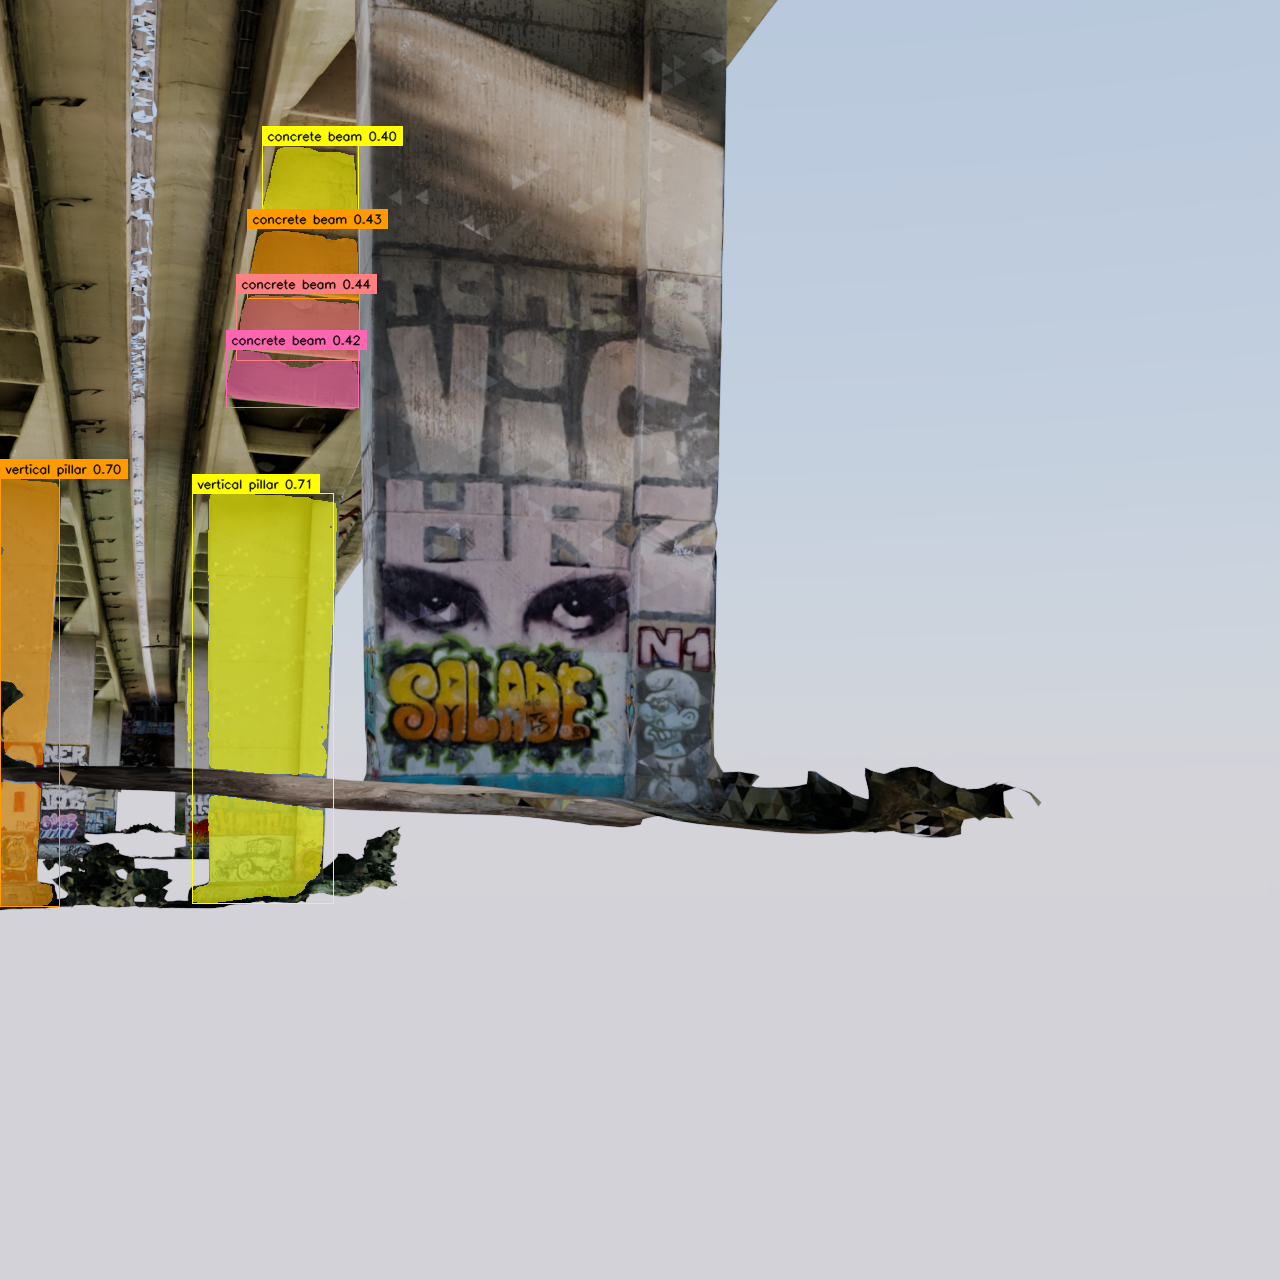

In [15]:
from PIL import Image
from IPython.display import display

PROMPT_1 = "vertical pillar"
PROMPT_2 = "concrete beam"
PROMPT_3 = "plant"
IMAGE_PATH = '/content/Data/rgb_00000.png'

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_1)
detections = from_sam(sam_result=inference_state)
detections_1 = detections[detections.confidence > 0.6]

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_2)
detections = from_sam(sam_result=inference_state)
detections_2 = detections[detections.confidence > 0.4]

inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT_2)
detections = from_sam(sam_result=inference_state)
detections_3 = detections[detections.confidence > 0.5]

print(f"There are {len(detections)} {PROMPT_1} objects detected in the image.\n")
print(f"There are {len(detections)} {PROMPT_2} objects detected in the image.\n")
print(f"There are {len(detections)} {PROMPT_3} objects detected in the image.\n")

image = annotate(image, detections_1, label=PROMPT_1)
image = annotate(image, detections_2, label=PROMPT_2)
image = annotate(image, detections_3, label=PROMPT_3)
image

# Batch Processing

### 1. Libraries

In [16]:
# @title
!pip install -q opencv-python scipy pycocotools tqdm

import numpy as np
import cv2
import json
from pathlib import Path
from collections import Counter
from tqdm import tqdm
from pycocotools import mask as mask_util
import math

print("✓ Additional dependencies installed!")

✓ Additional dependencies installed!


2. Masks post process

In [17]:
# @title
def post_process_masks(masks,
                       fill_holes=True,
                       close_gaps=True,
                       remove_sprinkles=False,
                       max_hole_area=8000,
                       closing_kernel_size=100,
                       max_sprinkle_area=100):
    """
    Advanced mask post-processing to fix incomplete SAM3 masks.

    This function addresses masks with missing parts inside bounding boxes by:
    1. Closing gaps using morphological operations
    2. Filling enclosed holes
    3. Removing noise/sprinkles

    Args:
        masks: numpy array of shape (n, H, W) - binary masks
        fill_holes: If True, fill holes completely enclosed by foreground
        close_gaps: If True, use morphological closing to connect broken regions
        remove_sprinkles: If True, remove small isolated foreground regions
        max_hole_area: Maximum area (pixels) of holes to fill (default: 8000)
        closing_kernel_size: Size of kernel for morphological closing (default: 100)
        max_sprinkle_area: Maximum area (pixels) of sprinkles to remove (default: 100)

    Returns:
        Processed masks with gaps closed, holes filled, and noise removed
    """
    if len(masks) == 0:
        return masks

    from scipy.ndimage import binary_fill_holes, label as scipy_label
    import cv2

    n = len(masks)
    processed_masks = masks.copy()

    if fill_holes or close_gaps or remove_sprinkles:
        operations = []
        if close_gaps:
            operations.append("closing gaps")
        if fill_holes:
            operations.append("filling holes")
        if remove_sprinkles:
            operations.append("removing sprinkles")
        print(f"\n🔄 Processing: {', '.join(operations)}...")

        gaps_closed = 0
        holes_filled = 0
        sprinkles_removed = 0

        for i in range(n):
            mask = processed_masks[i]
            mask_bool = mask.astype(bool)

            # Step 1: Morphological closing to connect broken regions
            if close_gaps and closing_kernel_size > 0:
                kernel = cv2.getStructuringElement(
                    cv2.MORPH_ELLIPSE,
                    (closing_kernel_size, closing_kernel_size)
                )
                mask_uint8 = mask_bool.astype(np.uint8)
                closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
                mask_bool = closed.astype(bool)

                pixels_added = np.sum(mask_bool & ~processed_masks[i].astype(bool))
                if pixels_added > 0:
                    gaps_closed += 1

                processed_masks[i] = mask_bool

            # Step 2: Fill completely enclosed holes
            if fill_holes:
                filled = binary_fill_holes(mask_bool)
                holes = filled & ~mask_bool
                labeled_holes, num_holes = scipy_label(holes)

                for hole_id in range(1, num_holes + 1):
                    hole_mask = (labeled_holes == hole_id)
                    hole_area = np.sum(hole_mask)

                    if hole_area <= max_hole_area:
                        mask_bool[hole_mask] = True
                        holes_filled += 1

                processed_masks[i] = mask_bool

            # Step 3: Remove small isolated foreground regions
            if remove_sprinkles and max_sprinkle_area > 0:
                labeled_regions, num_regions = scipy_label(mask_bool)

                if num_regions > 0:
                    region_sizes = [(region_id, np.sum(labeled_regions == region_id))
                                   for region_id in range(1, num_regions + 1)]

                    for region_id, region_size in region_sizes:
                        if region_size <= max_sprinkle_area:
                            region_mask = (labeled_regions == region_id)
                            mask_bool[region_mask] = False
                            sprinkles_removed += 1

                processed_masks[i] = mask_bool

        # Print summary
        status_parts = []
        if close_gaps and gaps_closed > 0:
            status_parts.append(f"{gaps_closed} masks closed (kernel={closing_kernel_size})")
        if fill_holes and holes_filled > 0:
            status_parts.append(f"{holes_filled} holes filled (≤{max_hole_area}px)")
        if remove_sprinkles and sprinkles_removed > 0:
            status_parts.append(f"{sprinkles_removed} sprinkles removed (≤{max_sprinkle_area}px)")

        if status_parts:
            print(f"   ✓ {', '.join(status_parts)}")
        else:
            print(f"   ℹ No changes needed")
    else:
        print(f"\n⏭ Skipping post-processing")

    return processed_masks

print("✓ Advanced mask post-processing function defined!")
print("   Features: gap closing, hole filling, noise removal")

✓ Advanced mask post-processing function defined!
   Features: gap closing, hole filling, noise removal


### 3. Consistent ID

In [18]:
# @title
def get_consistent_class_mapping(class_names, text_prompts):
    """
    Create consistent class IDs based on text prompt order.
    First prompt = ID 0, second = ID 1, etc.

    Args:
        class_names: List of class names detected
        text_prompts: List of text prompts (e.g., ["concrete pillar", "bridge deck"])

    Returns:
        Dictionary {class_name: class_id}
    """
    # Get unique detected classes
    unique_classes = list(set(class_names))

    # Map each detected class to prompt order
    class_to_id = {}
    for class_name in unique_classes:
        class_lower = class_name.lower()
        # Find matching prompt
        for idx, prompt in enumerate(text_prompts):
            prompt_lower = prompt.lower()
            if class_lower == prompt_lower or prompt_lower in class_lower or class_lower in prompt_lower:
                class_to_id[class_name] = idx
                break
        # If not found, assign next ID
        if class_name not in class_to_id:
            class_to_id[class_name] = len(text_prompts)

    return class_to_id

print("✓ Class mapping function defined!")

✓ Class mapping function defined!


### 4. Text prompts and threshold

In [19]:
# @title
# ==================== ADVANCED BATCH PROCESSING CONFIGURATION ====================

# Input/Output directories
IMAGES_DIRECTORY = "/content/Data"  # Input images folder
BATCH_OUTPUT_DIR = Path("/content/SAM3_batch_results")  # Output folder
BATCH_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Image file extensions to process
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png', 'bmp']

# Text prompts for detection with individual confidence thresholds
# Format: (prompt, confidence_threshold)
TEXT_PROMPTS = [
    ("concrete beam", 0.4),      # Confidence threshold for concrete beam
    ("vertical column", 0.6),    # Confidence threshold for vertical column
    ("bridge deck", 0.5)         # Confidence threshold for bridge deck
]

# Image range configuration
BATCH_START_INDEX = 0      # Start from this image (0-based)
BATCH_END_INDEX = 2       # Process up to this image (exclusive)
# Or set BATCH_END_INDEX = None to process all images from BATCH_START_INDEX

# Post-processing configuration
ENABLE_POST_PROCESSING = True
POST_PROCESS_CONFIG = {
    'fill_holes': True,
    'close_gaps': True,
    'remove_sprinkles': True,
    'max_hole_area': 8000,
    'closing_kernel_size': 100,
    'max_sprinkle_area': 100
}

print("✓ Advanced Batch Processing Configuration:")
print(f"   Input: {IMAGES_DIRECTORY}")
print(f"   Output: {BATCH_OUTPUT_DIR}")
print(f"   Text prompts: {TEXT_PROMPTS}")
print(f"   Range: {BATCH_START_INDEX} to {BATCH_END_INDEX if BATCH_END_INDEX else 'end'}")
print(f"   Post-processing: {'Enabled' if ENABLE_POST_PROCESSING else 'Disabled'}")
print(f"   Model: SAM 3 (native text-based detection + segmentation)")

✓ Advanced Batch Processing Configuration:
   Input: /content/Data
   Output: /content/SAM3_batch_results
   Text prompts: [('concrete beam', 0.4), ('vertical column', 0.6), ('bridge deck', 0.5)]
   Range: 0 to 2
   Post-processing: Enabled
   Model: SAM 3 (native text-based detection + segmentation)


## 5. Collect images

In [20]:
# @title
import glob

# Collect all image files
def get_image_files(directory, extensions):
    """Get all image files from directory with specified extensions"""
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(directory, f"*.{ext.lower()}")))
        image_files.extend(glob.glob(os.path.join(directory, f"*.{ext.upper()}")))
    return sorted(list(set(image_files)))

all_image_files = get_image_files(IMAGES_DIRECTORY, IMAGES_EXTENSIONS)
print(f"Found {len(all_image_files)} total images")

# Select range
if BATCH_END_INDEX is None:
    BATCH_END_INDEX = len(all_image_files)

BATCH_START_INDEX = max(0, min(BATCH_START_INDEX, len(all_image_files)))
BATCH_END_INDEX = max(BATCH_START_INDEX, min(BATCH_END_INDEX, len(all_image_files)))

batch_image_files = all_image_files[BATCH_START_INDEX:BATCH_END_INDEX]

print(f"\n✓ Will process {len(batch_image_files)} images (index {BATCH_START_INDEX} to {BATCH_END_INDEX-1})")
for i, img_file in enumerate(batch_image_files[:5]):
    print(f"   {BATCH_START_INDEX + i}: {os.path.basename(img_file)}")
if len(batch_image_files) > 5:
    print(f"   ... and {len(batch_image_files) - 5} more")

Found 8 total images

✓ Will process 2 images (index 0 to 1)
   0: rgb_00000.png
   1: rgb_00001.png


### 6. Process images

In [21]:
# @title
def process_single_image_sam3(img_path, sam3_processor, text_prompts, enable_post_processing=True, post_process_config=None):
    """Process a single image with SAM 3 native detection + segmentation"""
    try:
        # Load image
        pil_image = Image.open(img_path).convert("RGB")
        image_np = np.array(pil_image)
        h, w = image_np.shape[:2] if len(image_np.shape) == 3 else (image_np.shape[0], image_np.shape[1])

        # Set image in SAM 3 processor (once for all prompts)
        inference_state = sam3_processor.set_image(pil_image)

        # Process each text prompt
        all_masks = []
        all_boxes = []
        all_scores = []
        all_labels = []

        print(f"\n🔍 Processing {os.path.basename(img_path)}...")

        for prompt_config in text_prompts:
            # Extract prompt and threshold (support both tuple and string formats)
            if isinstance(prompt_config, tuple):
                prompt, confidence_threshold = prompt_config
            else:
                prompt = prompt_config
                confidence_threshold = 0.3  # Default threshold

            # SAM 3 native text-based detection + segmentation
            inference_state = sam3_processor.set_text_prompt(
                state=inference_state,
                prompt=prompt
            )

            # Extract results from inference state
            detections_sam = from_sam(sam_result=inference_state)

            # Apply per-class confidence threshold
            detections_sam = detections_sam[detections_sam.confidence > confidence_threshold]

            if len(detections_sam) > 0:
                print(f"   ✓ '{prompt}': {len(detections_sam)} detections (threshold={confidence_threshold})")

                # Collect results
                for idx in range(len(detections_sam)):
                    all_masks.append(detections_sam.mask[idx])
                    all_boxes.append(detections_sam.xyxy[idx])
                    all_scores.append(detections_sam.confidence[idx])
                    all_labels.append(prompt)
            else:
                print(f"   ℹ '{prompt}': no detections (threshold={confidence_threshold})")

        if len(all_masks) == 0:
            print(f"   ⚠ No detections found")
            return None

        # Convert to numpy arrays
        masks = np.array(all_masks)
        boxes = np.array(all_boxes)
        scores = np.array(all_scores)

        # Create class mapping first (extract prompt names from tuples)
        prompt_names = [p[0] if isinstance(p, tuple) else p for p in text_prompts]
        class_name_to_id = get_consistent_class_mapping(all_labels, prompt_names)
        class_ids = np.array([class_name_to_id[name] for name in all_labels])

        # Create temporary detections for NMS
        temp_detections = sv.Detections(
            xyxy=boxes,
            confidence=scores,
            class_id=class_ids,
            mask=masks.astype(bool)
        )

        # Apply NMS with IoU threshold of 0.5 (adjust if needed)
        nms_detections = temp_detections.with_nms(threshold=0.5)

        # Extract NMS results
        nms_indices = []
        for i, box in enumerate(nms_detections.xyxy):
            # Find matching box in original detections
            for j, orig_box in enumerate(boxes):
                if np.allclose(box, orig_box):
                    nms_indices.append(j)
                    break

        # Filter all arrays by NMS indices
        masks = masks[nms_indices]
        boxes = boxes[nms_indices]
        scores = scores[nms_indices]
        all_labels = [all_labels[i] for i in nms_indices]
        class_ids = class_ids[nms_indices]

        print(f"   ✓ Reduced from {len(temp_detections)} to {len(masks)} detections (removed {len(temp_detections) - len(masks)} overlaps)")

        # Apply advanced post-processing if enabled
        if enable_post_processing and post_process_config:
            masks = post_process_masks(masks=masks, **post_process_config)

        unique_class_names = list(set(all_labels))

        # Create detection labels with confidence scores
        confidences = scores.tolist() if hasattr(scores, 'tolist') else list(scores)
        detection_labels = [f"{label} {conf:.2f}" for label, conf in zip(all_labels, confidences)]

        # Create supervision Detections object
        detections = sv.Detections(
            xyxy=boxes,
            mask=masks.astype(bool),
            class_id=class_ids
        )

        return {
            'image_path': img_path,
            'image_source': image_np,
            'detections': detections,
            'labels': detection_labels,
            'class_names': all_labels,
            'confidences': confidences,
            'masks': masks,
            'scores': scores,
            'input_boxes': boxes,
            'unique_class_names': unique_class_names,
            'class_name_to_id': class_name_to_id
        }

    except Exception as e:
        print(f"❌ Error processing {os.path.basename(img_path)}: {e}")
        import traceback
        traceback.print_exc()
        return None

# Process all images
batch_results = []
print(f"\n🚀 Processing {len(batch_image_files)} images with SAM 3...")

for img_file in tqdm(batch_image_files, desc="Processing"):
    result = process_single_image_sam3(
        img_file,
        processor,
        TEXT_PROMPTS,
        enable_post_processing=ENABLE_POST_PROCESSING,
        post_process_config=POST_PROCESS_CONFIG if ENABLE_POST_PROCESSING else None
    )
    if result:
        batch_results.append(result)

print(f"\n✓ Successfully processed {len(batch_results)}/{len(batch_image_files)} images")


🚀 Processing 2 images with SAM 3...


Processing:   0%|          | 0/2 [00:00<?, ?it/s]


🔍 Processing rgb_00000.png...
   ✓ 'concrete beam': 4 detections (threshold=0.4)
   ✓ 'vertical column': 2 detections (threshold=0.6)
   ℹ 'bridge deck': no detections (threshold=0.5)
   ✓ Reduced from 6 to 6 detections (removed 0 overlaps)

🔄 Processing: closing gaps, filling holes, removing sprinkles...


Processing:  50%|█████     | 1/2 [00:08<00:08,  8.86s/it]

   ✓ 6 masks closed (kernel=100)

🔍 Processing rgb_00001.png...
   ✓ 'concrete beam': 16 detections (threshold=0.4)
   ✓ 'vertical column': 5 detections (threshold=0.6)
   ℹ 'bridge deck': no detections (threshold=0.5)
   ✓ Reduced from 21 to 21 detections (removed 0 overlaps)

🔄 Processing: closing gaps, filling holes, removing sprinkles...


Processing: 100%|██████████| 2/2 [00:29<00:00, 14.75s/it]

   ✓ 21 masks closed (kernel=100)

✓ Successfully processed 2/2 images


### 7. Visualize images

🖼 Visualizing 2 images (index 0 to 1)
   Grid: 2 columns


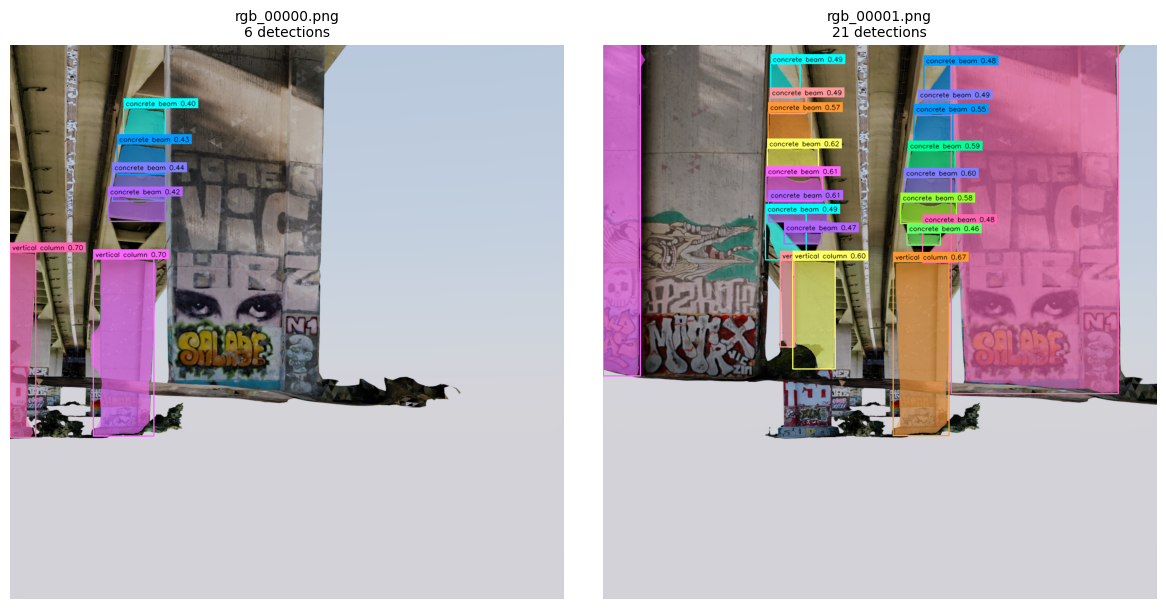


✓ Displayed 2 processed images


In [22]:
# @title
# ==================== VISUALIZE BATCH RESULTS ====================

# Configuration: Choose range of images to display
VIZ_START = 0      # Start index (0-based)
VIZ_END = 40        # End index (inclusive)
VIZ_COLS = 2       # Number of columns in grid

# Validate range
VIZ_START = max(0, min(VIZ_START, len(batch_results) - 1))
VIZ_END = max(VIZ_START, min(VIZ_END, len(batch_results) - 1))

results_to_show = batch_results[VIZ_START:VIZ_END + 1]

print(f"🖼 Visualizing {len(results_to_show)} images (index {VIZ_START} to {VIZ_END})")
print(f"   Grid: {VIZ_COLS} columns")

# Calculate grid dimensions
num_images = len(results_to_show)
num_rows = math.ceil(num_images / VIZ_COLS)

# Create figure
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_rows, VIZ_COLS, figsize=(VIZ_COLS * 6, num_rows * 6))
if num_rows == 1 and VIZ_COLS == 1:
    axes = np.array([[axes]])
elif num_rows == 1:
    axes = axes.reshape(1, -1)
elif VIZ_COLS == 1:
    axes = axes.reshape(-1, 1)

# Plot each image
for idx, result in enumerate(results_to_show):
    row = idx // VIZ_COLS
    col = idx % VIZ_COLS
    ax = axes[row, col]

    # Load and annotate image
    img = cv2.imread(result['image_path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Annotate
    mask_annotator = sv.MaskAnnotator(color=COLOR, color_lookup=sv.ColorLookup.INDEX, opacity=0.6)
    box_annotator = sv.BoxAnnotator(color=COLOR, color_lookup=sv.ColorLookup.INDEX, thickness=2)
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.5,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated = mask_annotator.annotate(scene=img_rgb.copy(), detections=result['detections'])
    annotated = box_annotator.annotate(scene=annotated, detections=result['detections'])
    annotated = label_annotator.annotate(scene=annotated, detections=result['detections'], labels=result['labels'])

    # Display
    ax.imshow(annotated)
    ax.set_title(f"{os.path.basename(result['image_path'])}\n{len(result['detections'])} detections", fontsize=10)
    ax.axis('off')

# Hide empty subplots
for idx in range(num_images, num_rows * VIZ_COLS):
    row = idx // VIZ_COLS
    col = idx % VIZ_COLS
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {len(results_to_show)} processed images")

### 8. Save resultd

In [23]:
# @title
print("💾 Saving batch results...")

# Create subdirectories
annotated_dir = BATCH_OUTPUT_DIR / "annotated_images"
individual_json_dir = BATCH_OUTPUT_DIR / "individual_results"
annotated_dir.mkdir(exist_ok=True)
individual_json_dir.mkdir(exist_ok=True)

# Helper function to convert mask to RLE
def single_mask_to_rle(mask):
    """Convert single mask to RLE format"""
    rle = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

# Batch results container
batch_json_results = {
    "processing_info": {
        "total_images": len(batch_image_files),
        "successfully_processed": len(batch_results),
        "text_prompts": TEXT_PROMPTS,
        "model_used": "SAM 3 (native text-based detection + segmentation)",
        "post_processing_enabled": ENABLE_POST_PROCESSING,
        "post_processing_config": POST_PROCESS_CONFIG if ENABLE_POST_PROCESSING else None
    },
    "images": []
}

# Process each result
for result in tqdm(batch_results, desc="Saving results"):
    img_path = result['image_path']
    image_name = os.path.basename(img_path)
    image_name_no_ext = os.path.splitext(image_name)[0]

    # Load original image for annotation
    img = cv2.imread(img_path)

    # Create annotated image
    mask_annotator = sv.MaskAnnotator(color=COLOR, color_lookup=sv.ColorLookup.INDEX, opacity=0.6)
    box_annotator = sv.BoxAnnotator(color=COLOR, color_lookup=sv.ColorLookup.INDEX, thickness=2)
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.5,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_full = mask_annotator.annotate(scene=img.copy(), detections=result['detections'])
    annotated_full = box_annotator.annotate(scene=annotated_full, detections=result['detections'])
    annotated_full = label_annotator.annotate(scene=annotated_full, detections=result['detections'], labels=result['labels'])

    # Save annotated image
    cv2.imwrite(str(annotated_dir / f"{image_name_no_ext}_annotated.jpg"), annotated_full)

    # Convert masks to RLE
    mask_rles = [single_mask_to_rle(mask) for mask in result['masks']]
    h, w, _ = result['image_source'].shape

    # Create JSON data
    image_result = {
        "image_name": image_name,
        "image_path": img_path,
        "img_width": w,
        "img_height": h,
        "num_detections": len(result['detections']),
        "unique_classes": result['unique_class_names'],
        "class_mapping": result['class_name_to_id'],
        "annotations": [
            {
                "class_name": class_name,
                "class_id": result['class_name_to_id'][class_name],
                "bbox": box.tolist(),
                "segmentation": mask_rle,
                "score": float(score),
                "confidence": float(confidence)
            }
            for class_name, box, mask_rle, score, confidence in zip(
                result['class_names'],
                result['input_boxes'],
                mask_rles,
                result['scores'],
                result['confidences']
            )
        ],
        "box_format": "xyxy"
    }

    # Save individual JSON
    with open(individual_json_dir / f"{image_name_no_ext}.json", "w") as f:
        json.dump(image_result, f, indent=2)

    batch_json_results["images"].append(image_result)

# Save combined batch JSON
with open(BATCH_OUTPUT_DIR / "batch_results.json", "w") as f:
    json.dump(batch_json_results, f, indent=2)

# Summary statistics
all_classes = []
for result in batch_results:
    all_classes.extend(result['class_names'])

class_counts = Counter(all_classes)

print(f"\n✓ Batch processing complete!")
print(f"   📁 Output: {BATCH_OUTPUT_DIR}")
print(f"   🖼 Images: {len(batch_results)}")
print(f"   🎯 Total detections: {sum(len(r['detections']) for r in batch_results)}")
print(f"   📊 Classes: {dict(class_counts)}")
print(f"\n📂 Output structure:")
print(f"   {BATCH_OUTPUT_DIR}/")
print(f"   ├── annotated_images/     (visualizations)")
print(f"   ├── individual_results/   (per-image JSON)")
print(f"   └── batch_results.json    (combined results)")

💾 Saving batch results...


Saving results: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


✓ Batch processing complete!
   📁 Output: /content/SAM3_batch_results
   🖼 Images: 2
   🎯 Total detections: 27
   📊 Classes: {'concrete beam': 20, 'vertical column': 7}

📂 Output structure:
   /content/SAM3_batch_results/
   ├── annotated_images/     (visualizations)
   ├── individual_results/   (per-image JSON)
   └── batch_results.json    (combined results)
